# BaseLine Code

- 약 106개의 이미지만을 사용하여 만든 baseline code

## Step 1. 실험환경 set-up

#### 라이브러리 실행

In [1]:
import re    # 정규표현식 관련된 작업에 필요한 패키지
import os    # I/O 관련된 작업에 필요한 패키지 
import pandas as pd     # 데이터 전처리 관련된 작업에 필요한 패키지
import numpy as np      # 데이터 array 작업에 필요한 패키지
import tensorflow as tf  # 딥러닝 관련된 작업에 필요한 패키지
import matplotlib.pyplot as plt    # 데이터 시각화에 관련된 작업에 필요한 패키지
from sklearn.model_selection import train_test_split  # 데이터 전처리에 필요한 패키지

#### 필요한 변수들 생성

In [2]:
# 데이터 로드할 때 빠르게 로드할 수 있도록하는 설정 변수
AUTOTUNE = tf.data.experimental.AUTOTUNE

# BATCH_SIZE 변수
BATCH_SIZE = 32

# 이미지 사이즈 변수
IMAGE_SIZE = [256, 256]

# EPOCH 크기 변수
EPOCHS = 30

## Step 2. 데이터 준비하기

먼저 아래의 링크에서 데이터를 다운 받을 것

https://drive.google.com/drive/folders/1Pi5qyX080zY2IdGT1TvvLraBO9DHBxJl?usp=sharing

받은 후 터미널 창에 아래의 명령어들을 차례로 입력

```
$ cd ~/Downloads && cp CellPin ~/aiffel
```

#### 데이터의 개수 확인

In [3]:
# 데이터 ROOT 경로 변수
ROOT_PATH = os.path.join(os.getenv('HOME'), 'aiffel/CellPin')
print(ROOT_PATH)

train_filenames = tf.io.gfile.glob(str(ROOT_PATH + '/train/*/*'))
# test_filenames = tf.io.gfile.glob(str(ROOT_PATH + '/test/*/*'))
# val_filenames = tf.io.gfile.glob(str(ROOT_PATH + '/val/*/*'))

print(len(train_filenames))
# print(len(test_filenames))
# print(len(val_filenames))

/home/aiffel-dj52/aiffel/CellPin
188


#### train과 validation을 80:20으로 분할

In [4]:
# filenames = tf.io.gfile.glob(str(ROOT_PATH + '/train/*/*'))
# filenames.extend(tf.io.gfile.glob(str(ROOT_PATH + '/test/*/*')))

train_filenames, test_filenames = train_test_split(train_filenames, test_size=0.2)

print(len(train_filenames))
print(len(test_filenames))

150
38


In [5]:
# filenames = tf.io.gfile.glob(str(ROOT_PATH + '/train/*/*'))
# filenames.extend(tf.io.gfile.glob(str(ROOT_PATH + '/val/*/*')))

train_filenames, val_filenames = train_test_split(train_filenames, test_size=0.2)

print(len(train_filenames))
print(len(val_filenames))

120
30


#### train 데이터 안에 정상 이미지 수와 CPE 이미지 수

In [6]:
COUNT_NORMAL = len([filename for filename in train_filenames if "normal" in filename])
print("NORMAL images count in training set: " + str(COUNT_NORMAL))

COUNT_CPE = len([filename for filename in train_filenames if "cpe" in filename])
print("CPE images count in training set: " + str(COUNT_CPE))

NORMAL images count in training set: 27
CPE images count in training set: 93


#### val 데이터 안에 정상 이미지 수와 CPE 이미지 수

In [7]:
COUNT_NORMAL = len([filename for filename in val_filenames if "normal" in filename])
print("NORMAL images count in training set: " + str(COUNT_NORMAL))

COUNT_CPE = len([filename for filename in val_filenames if "cpe" in filename])
print("CPE images count in training set: " + str(COUNT_CPE))

NORMAL images count in training set: 5
CPE images count in training set: 25


#### test 데이터 안에 정상 이미지 수와 CPE 이미지 수

In [8]:
COUNT_NORMAL = len([filename for filename in test_filenames if "normal" in filename])
print("NORMAL images count in training set: " + str(COUNT_NORMAL))

COUNT_CPE = len([filename for filename in test_filenames if "cpe" in filename])
print("CPE images count in training set: " + str(COUNT_CPE))

NORMAL images count in training set: 7
CPE images count in training set: 31


#### tf.data 인스턴스를 만들기

In [9]:
train_list_ds = tf.data.Dataset.from_tensor_slices(train_filenames)
val_list_ds = tf.data.Dataset.from_tensor_slices(val_filenames)

#### train data와 val data의 개수 확인

In [10]:
TRAIN_IMG_COUNT = tf.data.experimental.cardinality(train_list_ds).numpy()
print("Training images count: " + str(TRAIN_IMG_COUNT))

VAL_IMG_COUNT = tf.data.experimental.cardinality(val_list_ds).numpy()
print("Validating images count: " + str(VAL_IMG_COUNT))

Training images count: 120
Validating images count: 30


#### 라벨 이름들 확인

In [11]:
CLASS_NAMES = np.array([str(tf.strings.split(item, os.path.sep)[-1].numpy())[2:-1]
                        for item in tf.io.gfile.glob(str(ROOT_PATH + "/train/*"))])
print(CLASS_NAMES)

['cpe' 'normal']


#### 라벨링 함수를 만들어 보기

In [12]:
def get_label(file_path):
    parts = tf.strings.split(file_path, os.path.sep)
    return parts[-2] == "cpe"

#### decode_img 함수와 process_path 함수를 만들기

In [13]:
def decode_img(img):
  # 이미지를 uint8 tensor로 바꾼다.
  img = tf.image.decode_jpeg(img, channels=3)
  # img를 범위 [0,1]의 float32 데이터 타입으로 바꾼다.
  img = tf.image.convert_image_dtype(img, tf.float32)
  # img의 이미지 사이즈를 IMAGE_SIZE에서 지정한 사이즈로 수정한다.
  return tf.image.resize(img, IMAGE_SIZE)

def process_path(file_path):
    label = get_label(file_path)
    img = tf.io.read_file(file_path)
    img = decode_img(img)
    return img, label

#### train과 val에 함수들 적용해주기

In [14]:
train_ds = train_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
val_ds = val_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)

#### 전처리 함수 만들기 및 적용

In [15]:
def prepare_for_training(ds, shuffle_buffer_size=1000):

    ds = ds.shuffle(buffer_size=shuffle_buffer_size)

    ds = ds.repeat()

    ds = ds.batch(BATCH_SIZE)

    ds = ds.prefetch(buffer_size=AUTOTUNE)

    return ds

train_ds = prepare_for_training(train_ds)
val_ds = prepare_for_training(val_ds)

#### Image shape를 변경 체크하기

In [16]:
for image, label in train_ds.take(1):
    print("Image shape: ", image.numpy().shape)
    print("Label: ", label.numpy())

Image shape:  (32, 256, 256, 3)
Label:  [ True  True  True False  True  True  True  True False False  True  True
  True  True  True  True  True False  True  True  True False  True False
  True False  True  True  True False  True  True]


#### test 데이터 셋도 만들어 보기 & 데이터의 갯수 확인

In [17]:
# test_list_ds = tf.data.Dataset.list_files(str(ROOT_PATH + '/test/*/*'))
# TEST_IMAGE_COUNT = tf.data.experimental.cardinality(test_list_ds).numpy()
test_list_ds = tf.data.Dataset.from_tensor_slices(test_filenames)
test_ds = test_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
test_ds = test_ds.batch(BATCH_SIZE)

# print(TEST_IMAGE_COUNT)

## Step 3. 데이터 시각화

#### 16개의 샘플 꺼내서 확인

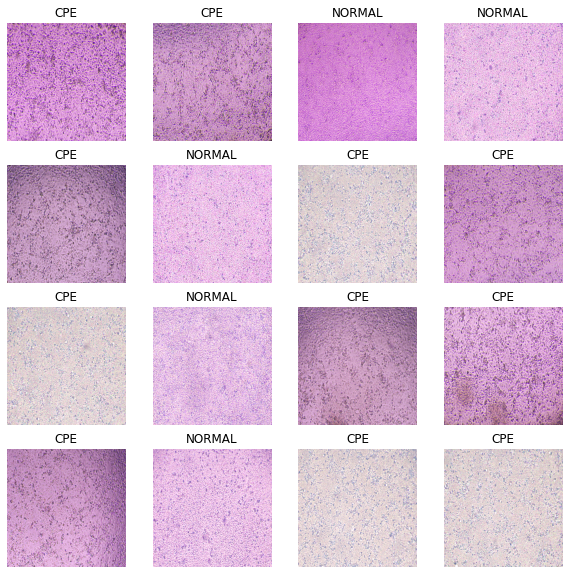

In [18]:
image_batch, label_batch = next(iter(train_ds))

def show_batch(image_batch, label_batch):
    plt.figure(figsize=(10,10))
    for n in range(16):
        ax = plt.subplot(4,4,n+1)
        plt.imshow(image_batch[n])
        if label_batch[n]:
            plt.title("CPE")
        else:
            plt.title("NORMAL")
        plt.axis("off")

show_batch(image_batch.numpy(), label_batch.numpy())

#### model building

In [19]:
densenet_layer = [
    tf.keras.applications.DenseNet201(include_top = False,
                                      weights = "imagenet",
                                      input_shape = (256, 256, 3),
                                      classes = 1)
]

fc_layer = [
    tf.keras.layers.GlobalMaxPool2D(),
    tf.keras.layers.Dense(1),
    tf.keras.layers.Activation('softmax')
]

densenet = tf.keras.models.Sequential(densenet_layer + fc_layer)

In [20]:
densenet.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
densenet201 (Functional)     (None, 8, 8, 1920)        18321984  
_________________________________________________________________
global_max_pooling2d (Global (None, 1920)              0         
_________________________________________________________________
dense (Dense)                (None, 1)                 1921      
_________________________________________________________________
activation (Activation)      (None, 1)                 0         
Total params: 18,323,905
Trainable params: 18,094,849
Non-trainable params: 229,056
_________________________________________________________________


## Step 5. 데이터 imbalance 처리

#### 이 weight들은 'Normal'과 'Cpe' 전체 데이터 건수에 반비례하도록 설정

In [21]:
weight_for_0 = (1 / COUNT_NORMAL)*(TRAIN_IMG_COUNT)/2.0 
weight_for_1 = (1 / COUNT_CPE)*(TRAIN_IMG_COUNT)/2.0

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for class 0: {:.2f}'.format(weight_for_0))
print('Weight for class 1: {:.2f}'.format(weight_for_1))

Weight for class 0: 8.57
Weight for class 1: 1.94


## Step 6. 모델 훈련

#### GPU사용하여 model complie

In [22]:
with tf.device('/GPU:0'):
    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
    densenet.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=METRICS
    )
    
    # early_stopping = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', patience = 2, restore_best_weights = True)
    check_point = tf.keras.callbacks.ModelCheckpoint(ROOT_PATH + '/pre_training_model/best_model_test.h5')

In [23]:
# tf.keras.utils.plot_model(densenet, to_file = "model.png", show_shapes = True, show_layer_names = False)

#### 모델 fitting

In [ ]:
with tf.device('/GPU:0'):
    history = densenet.fit(
        train_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_ds,
        validation_steps=2, # VAL_IMG_COUNT // BATCH_SIZE
        class_weight=class_weight,
        callbacks=[check_point]
    )

Instructions for updating:
The `validate_indices` argument has no effect. Indices are always validated on CPU and never validated on GPU.
Epoch 1/30
3/3 [==============================] - 80s 19s/step - loss: 3.2920 - accuracy: 0.7708 - precision: 0.7708 - recall: 1.0000 - val_loss: 2.5002 - val_accuracy: 0.8125 - val_precision: 0.8125 - val_recall: 1.0000
Epoch 2/30
3/3 [==============================] - 47s 17s/step - loss: 5.9503 - accuracy: 0.8125 - precision: 0.8125 - recall: 1.0000 - val_loss: 11.6198 - val_accuracy: 0.8125 - val_precision: 0.8125 - val_recall: 1.0000
Epoch 3/30
3/3 [==============================] - 49s 18s/step - loss: 0.5582 - accuracy: 0.6979 - precision: 0.6979 - recall: 1.0000 - val_loss: 27.8329 - val_accuracy: 0.8281 - val_precision: 0.8281 - val_recall: 1.0000
Epoch 4/30
3/3 [==============================] - 50s 18s/step - loss: 0.3730 - accuracy: 0.8438 - precision: 0.8438 - recall: 1.0000 - val_loss: 34.0996 - val_accuracy: 0.8438 - val_precision: 0.8

## Step 7. 결과 확인 및 시각화

In [ ]:
fig, ax = plt.subplots(2, 2, figsize=(10, 10))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

## Step 8. 최종 Test dataset 검정하기

In [ ]:
model = tf.keras.models.load_model(ROOT_PATH + '/pre_training_model/best_model_test.h5')
loss, acc, prec, rec = model.evaluate(test_ds)

## Discussion